In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets.vision import VisionDataset
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

import cv2 as cv
import numpy as np

import requests
import copy

from pathlib import Path
from PIL import Image
from imutils.paths import list_images
import os

In [2]:
from pv_vision.nn import ModelHandler

In [16]:
# will put this method into util in the future
class SolarDataset(VisionDataset):
    """A dataset directly read images and masks from folder.    
    """
    def __init__(self, 
                 root, 
                 image_folder, 
                 mask_folder,
                 transforms,
                 mode = "train",
                 random_seed=42):
        super().__init__(root, transforms)
        self.image_path = Path(self.root) / image_folder
        self.mask_path = Path(self.root) / mask_folder

        if not os.path.exists(self.image_path):
            raise OSError(f"{self.image_path} not found.")

        if not os.path.exists(self.mask_path):
            raise OSError(f"{self.mask_path} not found.")

        self.image_list = sorted(list(list_images(self.image_path)))
        self.mask_list = sorted(list(list_images(self.mask_path)))

        self.image_list = np.array(self.image_list)
        self.mask_list = np.array(self.mask_list)

        np.random.seed(random_seed)
        index = np.arange(len(self.image_list))
        np.random.shuffle(index)
        self.image_list = self.image_list[index]
        self.mask_list = self.mask_list[index]

    def __len__(self):
        return len(self.image_list)

    def __getname__(self, index):
        image_name = os.path.splitext(os.path.split(self.image_list[index])[-1])[0]
        mask_name = os.path.splitext(os.path.split(self.mask_list[index])[-1])[0]

        if image_name == mask_name:
            return image_name
        else:
            return False
    
    def __getraw__(self, index):
        if not self.__getname__(index):
            raise ValueError("{}: Image doesn't match with mask".format(os.path.split(self.image_list[index])[-1]))
        image = Image.open(self.image_list[index])
        mask = Image.open(self.mask_list[index]).convert('L')
        mask = np.array(mask)
        mask = Image.fromarray(mask)

        return image, mask

    def __getitem__(self, index):
        image, mask = self.__getraw__(index)
        image, mask = self.transforms(image, mask)

        return image, mask

In [4]:
# will put into utils in the future
class Compose:
    def __init__(self, transforms):
        """
        transforms: a list of transform
        """
        self.transforms = transforms
    
    def __call__(self, image, target):
        """
        image: input image
        target: input mask
        """
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class FixResize:
    # UNet requires input size to be multiple of 16
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = F.resize(image, (self.size, self.size), interpolation=transforms.InterpolationMode.BILINEAR)
        target = F.resize(target, (self.size, self.size), interpolation=transforms.InterpolationMode.NEAREST)
        return image, target

class ToTensor:
    """Transform the image to tensor. Scale the image to [0,1] float32.
    Transform the mask to tensor.
    """
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

class PILToTensor:
    """Transform the image to tensor. Keep raw type."""
    def __call__(self, image, target):
        image = F.pil_to_tensor(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

class Normalize:
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.mean = mean
        self.std = std
    
    def __call__(self, image, target):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target

In [17]:
# The images and lables are only for tutorial demosntration.
# The complete data set we used for model development can be found here:
# https://datahub.duramat.org/dataset/00b29daf-239c-47b6-bd96-bfb0875179a8/resource/c6626a05-e82f-4732-ade9-ec5441b83e46/download/crack_segmentation.zip

root = Path('../examples/crack_segmentation/img_label_for_training')
transformers = Compose([FixResize(256), ToTensor(), Normalize()])

trainset = SolarDataset(root, image_folder="train/img", 
        mask_folder="train/ann", transforms=transformers)

valset = SolarDataset(root, image_folder="val/img", 
        mask_folder="val/ann", transforms=transformers)

testset = SolarDataset(root, image_folder="testset/img", 
        mask_folder="testset/ann", transforms=transformers)


In [6]:
def DeepLab_pretrained(num_classes):
    deeplab = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
    deeplab.classifier = DeepLabHead(2048, num_classes)
    return deeplab

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DataParallel(DeepLab_pretrained(5))
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)
lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.2)

In [32]:
# initialize modelhandler
# The output is stored in the output folder
modelhandler = ModelHandler(
    model=model,
    model_output='out',
    train_dataset=trainset,
    val_dataset=valset,
    test_dataset=testset,
    batch_size_train=32,
    batch_size_val=32,
    lr_scheduler=lr_scheduler,
    num_epochs=10,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    save_dir='checkpoints',
    save_name='deeplab.pt'
)


In [11]:
# train the model. Note that this tutorial only runs 10 epochs. 
# It may take longer training iteration in real situation.
modelhandler.train_model()

Epoch 1 / 10
----------


100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Loss: 0.4173 (train) | 4.9578 (val)
Epoch 2 / 10
----------


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Loss: 0.1789 (train) | 0.1916 (val)
Epoch 3 / 10
----------


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Loss: 0.1192 (train) | 0.1170 (val)
Epoch 4 / 10
----------


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Loss: 0.1049 (train) | 0.1077 (val)
Epoch 5 / 10
----------


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Loss: 0.0942 (train) | 0.0964 (val)
Epoch 6 / 10
----------


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Loss: 0.0882 (train) | 0.0882 (val)
Epoch 7 / 10
----------


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Loss: 0.0849 (train) | 0.0861 (val)
Epoch 8 / 10
----------


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Loss: 0.0839 (train) | 0.0836 (val)
Epoch 9 / 10
----------


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Loss: 0.0826 (train) | 0.0833 (val)
Epoch 10 / 10
----------


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]

Loss: 0.0800 (train) | 0.0824 (val)


{'train': {'loss': [0.4173066987054338,
   0.17885671862604197,
   0.1192198520825233,
   0.1049448441514753,
   0.09418112763161522,
   0.08817903688292444,
   0.0848550075059565,
   0.08386343555072698,
   0.08257343704379144,
   0.07998113717439244]},
 'val': {'loss': [4.957792570424634,
   0.19160857034284015,
   0.11703312431657037,
   0.10774861033572707,
   0.09641222534484642,
   0.08819531077562376,
   0.08607308133396992,
   0.08364118046538774,
   0.08325028124936791,
   0.08244443407585454]}}

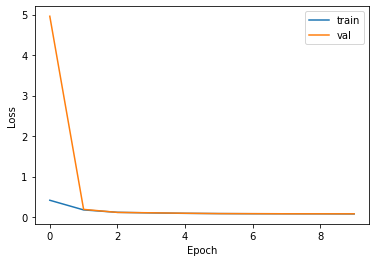

In [11]:
# visualize training process
modelhandler.plot_loss()

In [13]:
# find the minimum loss in validation, which is the best model
np.argmin(modelhandler.running_record['val']['loss'])+1

10

In [9]:
# we can load the best model and check its performance on testing set
modelhandler.load_model('checkpoints/epoch_10/deeplab.pt')

In [33]:
_ = modelhandler.test_model(cache_output='testset_output')
# Not bad. The testing score is similar to validation score
# the output of the model is stored in self.cache['testset_output']

Testing mode
----------


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

Test set: Average loss: 0.0780
